## Predicting AD Feature Engineering and Modeling
The goal of this post is to get others started with loading, cleaning, feature engineering, and modeling the data. This notebook requires a utility script that is attached separately. Feel free to use the functions as a starting point to get ideas for your own cleaning and feature engineering.

In [ ]:

import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from previous_codes.utility import get_final_features,  TrainML, get_cat_cols, encode_cat_cols, feature_engineering
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import optuna
import warnings
warnings.filterwarnings("ignore")

## Load the Data
To start, we'll load the data. This chunk of code allows you to load the data from your local files and merge them to the train and test datasets OR you can load your presaved train and test sets by changing "load_saved_data" to True. The code block will load the data and print the number of train and test columns.

In [ ]:
root_dir = os.getcwd()
load_saved_data = False      # if you change this to true you can load presaved data

if not load_saved_data: 
    test_fname= os.path.join(root_dir, "../dataset/test_features.csv")
    trainX_fname = os.path.join(root_dir,  "../dataset/train_features.csv")
    trainy_fname = os.path.join(root_dir,  "../dataset/train_labels.csv")
    sample_submission_fname = os.path.join(root_dir,  "../dataset/submission_format.csv")
    
    train_data=pd.merge(pd.read_csv(trainX_fname), pd.read_csv(trainy_fname), on='uid', how='inner')
    train_data.to_csv(os.path.join(root_dir, "../dataset/train_data.csv"), index=False)
    test_data=pd.merge(pd.read_csv(test_fname), pd.read_csv(sample_submission_fname), on='uid', how='inner')
    test_data.to_csv(os.path.join(root_dir, "../dataset/test_data.csv"), index=False)
else:
    train_data=pd.read_csv(os.path.join(root_dir, "../dataset/train_data.csv"))
    test_data=pd.read_csv(os.path.join(root_dir, "../dataset/test_data.csv"))
print('train columns: ', len(train_data.columns))
print('test columns: ', len(test_data.columns))


train columns:  186
test columns:  186


## Feature Engineering
This next part involves generating new features from the original data. You can refer to the function "feature_engineering" in utility.py to see which features I used. However, this is just a starting point. You can use that template to generate more or less features depending on what you uncover in your analysis.

In [3]:
train_data=feature_engineering(train_data)
test_data=feature_engineering(test_data)



After we create the new features, we need to identify and encode the categorical columns. There were a lot of categorical columns in this data set, so I start by encoding all of them but then we will narrow down the number of features to keep. In the utility script, I also drop features after combining some of the raw data into my new features.

In [4]:
cat_cols, dummy_cols=get_cat_cols(train_data)
cat_cols_test, dummy_cols_test=get_cat_cols(test_data)




In [5]:
train_data, test_data, dummy_feature_names=encode_cat_cols(train_data ,test_data, cat_cols, dummy_cols)

Here, I write my cleaned train data to a csv so that I can examine it further. It's suggested that you use your clean dataframe to do some EDA and pull descriptive statistics and visualizations to help you determine what you need to continue to work on.

In [6]:
train_data.to_csv('train_data_clean.csv')

## Handling Missing Values
In this next section, I go through each of the columns in the test set and if there is more than 50% of the values missing in a column, I drop the column. If there is more than 5% missing, I fill the values with 0 and print the percent of missing values for the respective column. If the column has less than 5% missing values, we simply fill any missing values with 0 but don't print anything.

In [7]:
test_columns=test_data.columns

for col in train_data[test_columns]: 
    if round((train_data[col].isna().sum() /len(train_data)*100), 2)>50:
        train_data.drop(columns=col, inplace=True)
        test_data.drop(columns=col)
    elif round((train_data[col].isna().sum() /len(train_data)*100), 2)>5:
        print(col,round((train_data[col].isna().sum() /len(train_data)*100), 2), '% missing')
        train_data[col].fillna(0, inplace=True)
        test_data[col].fillna(0, inplace=True)
        
    else: 
        train_data[col].fillna(0, inplace=True)
        test_data[col].fillna(0, inplace=True)


n_mar_03 34.12 % missing
glob_hlth_03 37.35 % missing
n_adl_03 33.73 % missing
n_iadl_03 37.32 % missing
n_depr_03 37.49 % missing
n_illnesses_03 33.53 % missing
decis_personal_03 37.49 % missing
glob_hlth_12 5.87 % missing
n_iadl_12 5.92 % missing
n_depr_12 6.56 % missing
memory_12 6.7 % missing
rearnings_03 33.55 % missing
searnings_03 49.67 % missing
hinc_business_03 33.13 % missing
hinc_rent_03 33.13 % missing
hinc_assets_03 33.13 % missing
hinc_cap_03 33.13 % missing
rinc_pension_03 33.55 % missing
sinc_pension_03 49.67 % missing
searnings_12 34.91 % missing
sinc_pension_12 34.91 % missing
rjob_hrswk 44.99 % missing


## Feature Selection
The "final_features" function that I created selects the features correlated with the target variable. Then, the featuers are compared and any columns that are highly correlated with each other are dropped to prevent redundant features. The threshold for the redundant features is the parameter for the function.

In [8]:
final_features=get_final_features(train_data, .7)

len(final_features)


125

In [9]:
final_features

['test_diab_03',
 'n_living_child_03_3. 5 or 6',
 'rjobend_reason_12_1.Retired',
 'energetic_12',
 'seg_pop_12',
 'comms_tel_comp_12',
 'restless_12',
 'rameduc_m_3.Primary',
 'depressed_12',
 'rafeduc_m_2.Some primary',
 'table_games_12',
 'adl_walk_12',
 'rameduc_m_2.Some primary',
 'rjob_hrswk',
 'rjlocc_m_12_12.Department Heads/Coordinators/Supervisors in Admin and Service Activities',
 'stroke_12',
 'n_living_child_03_1. 1 or 2',
 'decis_personal_12_3. None',
 'j11_12_Mud 3',
 'married_12_3. Widowed',
 'visit_dental_12',
 'rsocact_m_12_9.Never',
 'n_mar_03',
 'tv_12',
 'happy_03',
 'a34_12_Yes 1',
 'n_living_child_12_2. 3 or 4',
 'decis_personal_03',
 'employment_03_House',
 'glob_hlth_12',
 'rrelgimp_12_3.not important',
 'alc_tob',
 'arthritis_03',
 'test_diab_12',
 'rjlocc_m_12_7.Bosses/Supervisors etc in Artistic, Ind. Production, Repair, Maintenance Activities',
 'depressed_03',
 'n_living_child_12_1. 1 or 2',
 'rsocact_m_12_2.4 or more times a week',
 'lonely_03',
 'age_03_2

### Adding back in Year
"Year" is not highly correlated with the target feature but I add it back into the final features for modeling.

In [10]:
for f in final_features:
    if f=='year' :
        print(f)

In [11]:
final_features.append('year')
final_features.remove('composite_score')

In [12]:

train_data[final_features].head()

,test_diab_03,n_living_child_03_3. 5 or 6,rjobend_reason_12_1.Retired,energetic_12,seg_pop_12,comms_tel_comp_12,restless_12,rameduc_m_3.Primary,depressed_12,rafeduc_m_2.Some primary,...,attends_club_12,rsocact_m_12_1.Almost every day,iadl_meals_12,satis_ideal_12_nan,sewing_12,rameduc_m_1.None,married_12_1. Married or in civil union,rinc_pension_03,"rjlocc_m_12_5.Officials and Directors Public, Private, and Social Sectors",year
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2021
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2021
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2016
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2021
4,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2021


## Scaling the Data
I use a MinMaxScaler for this project because I'm not selecting the specific columns to scale. Ideally, you should use a column transformer to ensure that you're only scaling the continuous columns and skip the dummy coded columns, but this was easier to start with.

In [13]:

scaler=MinMaxScaler()

In [14]:
# set your random seed and the number of splits for cross validation
SEED=45
n_splits=3



## Modeling
The next few code blocks use baseline models to test performance. The dummypipeline uses a DummyRegressor that just predicts the mean value for everything. This gives us an idea of how a model with no skill performs. If our model doesn't perform better than this, it's essentially a failure.

In [15]:
#get baseline value from dummy regressor
dummypipeline=Pipeline([('tr', scaler), ('dummy', DummyRegressor(strategy="mean"))], verbose = True)
TrainML(dummypipeline,train_data, final_features, n_splits,SEED)

Training Folds: 100%|██████████| 3/3 [00:00<00:00, 43.10it/s]

Mean Train RMSE --> 60.4704
Mean Validation RMSE ---> 60.4692


### Catboost Regressor

In [16]:
#catboost classifier
pipeline=Pipeline([('tr', scaler), ('cat', CatBoostRegressor(  verbose=False))], verbose = True)
TrainML(pipeline,train_data, final_features,n_splits,SEED)

Training Folds: 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

Mean Train RMSE --> 18.7956
Mean Validation RMSE ---> 38.6334


### LGBM Regressor

In [20]:
#lgbm regressor
pipeline=Pipeline([('tr', scaler), ('lgbm', LGBMRegressor(verbosity=-1))], verbose = True)
TrainML(pipeline,train_data, final_features,n_splits,SEED)

Training Folds: 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

Mean Train RMSE --> 21.5806
Mean Validation RMSE ---> 39.5776


### XGBoost Regressor

In [18]:
from xgboost.sklearn import XGBRegressor
pipeline=Pipeline([('tr', scaler), ('xgb', XGBRegressor(  verbose=False))], verbose = True)
TrainML(pipeline,train_data, final_features,n_splits,SEED)

Training Folds: 100%|██████████| 3/3 [00:00<00:00,  8.83it/s]

Mean Train RMSE --> 9.5208
Mean Validation RMSE ---> 40.5220


### Lasso Regression

In [19]:
lasso = Lasso(alpha=1)  # Adjust alpha (regularization strength) as needed
pipeline=Pipeline([('tr', scaler), ('lasso', lasso)], verbose = True)
TrainML(pipeline,train_data, final_features,n_splits,SEED)

Training Folds: 100%|██████████| 3/3 [00:00<00:00, 35.04it/s]

Mean Train RMSE --> 41.4212
Mean Validation RMSE ---> 41.9880


### Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor()
pipeline=Pipeline([('tr', scaler), ('rf', rf)], verbose = True)
TrainML(pipeline,train_data, final_features,n_splits,SEED)

Training Folds: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

Mean Train RMSE --> 14.6738
Mean Validation RMSE ---> 39.1480


## Tuning the models
To get a better idea of how the models perform, I do a more rigorous CV process involving getting the unique ids so we don't bias our model towards individuals iwth multiple years of data. Then I get my train, val, and eval sets so that I can use Optuna to test out different hyperparameters and confirm on an unseen dataset.

For my starting notebook, we will just tune the Catboost Regressor and LGBM Regressor.

In [17]:

unique_uids = train_data['uid'].unique()
train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=SEED)
val_ids, eval_ids = train_test_split(val_ids, test_size=0.5, random_state=SEED)
X_train, X_val,X_eval = train_data[train_data['uid'].isin(train_ids)][final_features],train_data[train_data['uid'].isin(val_ids)][final_features] , train_data[train_data['uid'].isin(eval_ids)][final_features] 
y_train, y_val,y_eval = train_data[train_data['uid'].isin(train_ids)]['composite_score'],train_data[train_data['uid'].isin(val_ids)]['composite_score'] , train_data[train_data['uid'].isin(eval_ids)]['composite_score'] 




In [18]:
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_eval=scaler.transform(X_eval)

In [21]:
xgb = XGBRegressor(  verbose=False)


xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_val).round(0).astype(int)
mean_squared_error(y_val, y_pred, squared=False)

NameError: name 'XGBRegressor' is not defined

In [22]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 3e-2, 1e-1, log=True)
    param['depth'] = trial.suggest_int('depth', 7,10)
    param['iterations'] = trial.suggest_int('iterations', 100, 500)
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 1000
    param['random_state'] = SEED
    param['logging_level'] = 'Silent'
    
    regressor = CatBoostRegressor(**param)
    
    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=100)
    loss = mean_squared_error(y_val, regressor.predict(X_val.copy()), squared=False)
    return loss

study = optuna.create_study(study_name=f'catboost-seed{SEED}')
study.optimize(objective, n_trials=10, n_jobs=-1,show_progress_bar=True, timeout=24000)

[I 2024-12-17 15:05:13,984] A new study created in memory with name: catboost-seed45


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-12-17 15:05:18,943] Trial 0 finished with value: 39.812576634749476 and parameters: {'learning_rate': 0.08445978930490199, 'depth': 8, 'iterations': 408}. Best is trial 0 with value: 39.812576634749476.
[I 2024-12-17 15:05:19,232] Trial 1 finished with value: 39.47530794452263 and parameters: {'learning_rate': 0.03264870635393262, 'depth': 7, 'iterations': 291}. Best is trial 1 with value: 39.47530794452263.
[I 2024-12-17 15:05:20,742] Trial 7 finished with value: 39.23637592910602 and parameters: {'learning_rate': 0.0501466437032854, 'depth': 7, 'iterations': 438}. Best is trial 7 with value: 39.23637592910602.
[I 2024-12-17 15:05:21,760] Trial 5 finished with value: 39.29807884739222 and parameters: {'learning_rate': 0.09879394408303196, 'depth': 8, 'iterations': 386}. Best is trial 7 with value: 39.23637592910602.
[I 2024-12-17 15:05:22,732] Trial 8 finished with value: 39.38868199331921 and parameters: {'learning_rate': 0.09033608221876513, 'depth': 7, 'iterations': 472}. B

Take the study's best hyperparameters and assign them to "cat_params" to use going forward.

In [24]:
cat_params=study.best_params

In [25]:
cat_params

{'subsample': 0.4615412074649046,
 'learning_rate': 0.01903188667228612,
 'max_depth': 15,
 'num_leaves': 25}

In [26]:

cat = CatBoostRegressor(**cat_params, verbose=False)


cat.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=100)
y_pred = cat.predict(X_val).round(0).astype(int)
mean_squared_error(y_val, y_pred, squared=False)

39.65091216707065

### Feature Importance
Let's look at the top features in the catboost model

In [27]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)


In [31]:
df_train=train_data[final_features]
top_features=list(df_train.columns[sorted_idx[:20]])
df_train[top_features].head()

,rjobend_reason_12_1.Retired,happy_03,rjlocc_m_12_2.Technicians,care_adult_12,rjlocc_m_12_13.Administrative Support Staff,insur_private_12,rjlocc_m_12_12.Department Heads/Coordinators/Supervisors in Admin and Service Activities,rameduc_m_3.Primary,seg_pop_12,"rjlocc_m_12_5.Officials and Directors Public, Private, and Social Sectors","rjlocc_m_12_7.Bosses/Supervisors etc in Artistic, Ind. Production, Repair, Maintenance Activities",rjlocc_m_12_9.Operators of Fixed Machinery and Equipment for Ind. Production,rjlocc_m_12_1.Professionals,sgender_03_2.Woman,a34_12_Yes 1,n_living_child_03_1. 1 or 2,decis_personal_12_3. None,rrelgimp_03_1.very important,volunteer_12,rjlocc_m_12_3.Educators
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [23]:
def objective(trial):
    
    
    param = {
        'metric': 'rmse', 
        'random_state': SEED,
        'n_estimators': 300,
        'subsample': trial.suggest_loguniform('subsample', 2e-1,.9), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 5e-3,6e-2), 
        'max_depth': trial.suggest_int('max_depth', 10, 35),
        'num_leaves' : trial.suggest_int('num_leaves', 5, 200)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())])
    
    
    
    loss = mean_squared_error(y_val, model.predict(X_val.copy()), squared=False)
    return loss

study = optuna.create_study(study_name=f'lgbm-seed{SEED}')
study.optimize(objective, n_trials=50, n_jobs=-1,show_progress_bar=True, timeout=24000)

[I 2024-12-17 15:11:36,506] A new study created in memory with name: lgbm-seed45


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 3469, number of used features: 122
[LightGBM] [Info] Number of data points in the train set: 3469, number of used features: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 157.103200
[LightGBM] [Inf

KeyboardInterrupt: 

In [33]:
lgb_params=study.best_params
lgb=LGBMRegressor(**lgb_params,verbosity=-1)
lgb.fit(X_train,y_train)
y_pred = lgb.predict(X_val).round(0).astype(int)
mean_squared_error(y_val, y_pred, squared=False)

41.22732695995352

## Test the Model(s)
Fit the final models to the full training set and then predict the test data.

In [34]:

X=train_data[final_features]

X_test=test_data[final_features]

y=train_data['composite_score']
X=scaler.fit_transform(X)

cat = CatBoostRegressor(**cat_params, verbose=False)

cat.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=100)
X_test=scaler.transform(X_test)
y_pred_cat=cat.predict(X_test)

y_pred_lgb=lgb.predict(X_test)




## Final Test Predictions
We can visualize the distribution of the test predictions compared to the training set and describe the values to see if they make sense. Then we can write the submission to a csv.

In [35]:
sample_submission_fname = os.path.join(root_dir,  "data/submission_format.csv")
submission=pd.read_csv(sample_submission_fname)

submission['composite_score']=y_pred_cat.round(0).astype(int)


submission.head(10)

,uid,year,composite_score
0,abxu,2016,185
1,aeol,2016,209
2,aeol,2021,199
3,afnb,2016,190
4,afnb,2021,184
5,ajfh,2016,148
6,ajfh,2021,145
7,ajvq,2021,206
8,akbn,2016,125
9,akcw,2021,175


In [36]:
submission['composite_score'].describe()

count    1105.000000
mean      156.256109
std        45.605592
min        54.000000
25%       117.000000
50%       154.000000
75%       192.000000
max       266.000000
Name: composite_score, dtype: float64

(array([ 26.,  81., 171., 128., 182., 152., 170., 113.,  59.,  23.]),
 array([ 54. ,  75.2,  96.4, 117.6, 138.8, 160. , 181.2, 202.4, 223.6,
        244.8, 266. ]),
 <BarContainer object of 10 artists>)

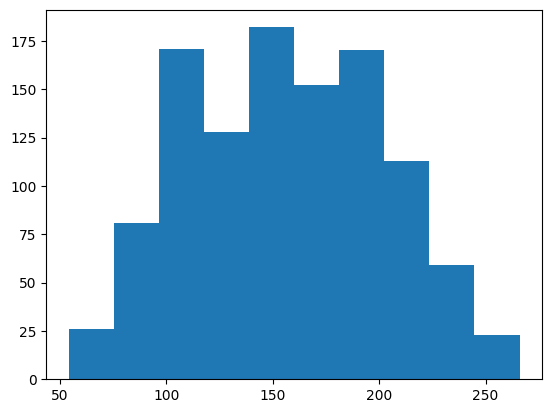

In [37]:
plt.hist(submission['composite_score'])

(array([136., 186., 505., 761., 879., 833., 573., 332., 113.,  25.]),
 array([  4.,  37.,  70., 103., 136., 169., 202., 235., 268., 301., 334.]),
 <BarContainer object of 10 artists>)

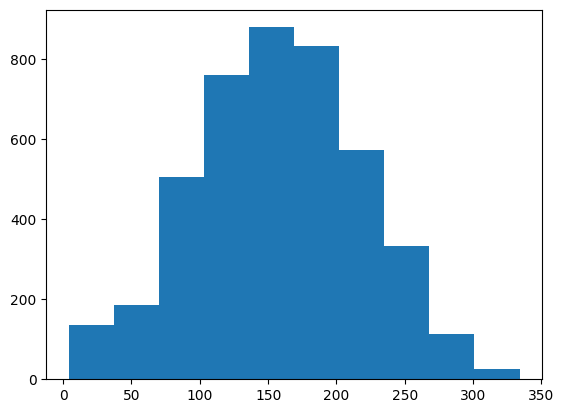

In [38]:
plt.hist(train_data['composite_score'])

In [39]:
train_data['composite_score'].describe()

count    4343.000000
mean      157.016809
std        60.909546
min         4.000000
25%       114.000000
50%       157.000000
75%       200.000000
max       334.000000
Name: composite_score, dtype: float64

In [ ]:
submission[['uid','year','composite_score']].to_csv('../dataset/submission.csv', index=False)

In [40]:
submission.head()

,uid,year,composite_score
0,abxu,2016,185
1,aeol,2016,209
2,aeol,2021,199
3,afnb,2016,190
4,afnb,2021,184
